1) Se cargan las librerias necesarias

In [436]:
# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Selección y validación de modelos
from sklearn.model_selection import KFold, cross_val_predict

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Técnicas de balanceo de clases
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

2) Se carga la base de datos

In [437]:
medical_appointments = pd.read_csv('Attendance of Medical Appointments in Brazil (may2016).csv')

3. Visualizacion de datos

In [438]:
# Numero de filas y columnas
medical_appointments.shape

(110527, 14)

In [439]:
# Encabezados
medical_appointments.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [440]:
# Tipo de datos
data_types = medical_appointments.dtypes
print(data_types)


PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object


In [441]:
# Numero de valores unicos por columna
column_counts = medical_appointments.nunique()
print(column_counts)

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64


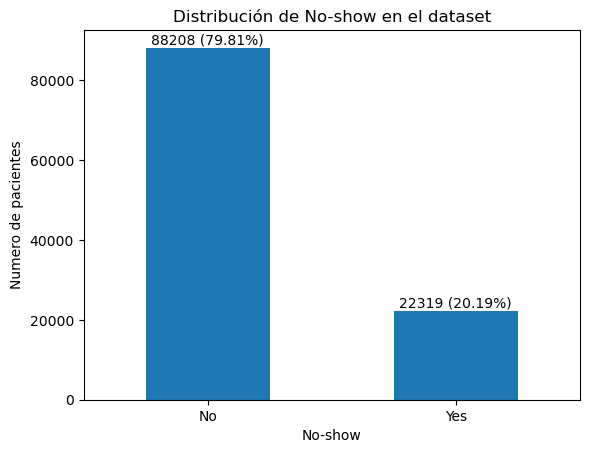

In [442]:
# Distribución del dataset
class_counts = medical_appointments['No-show'].value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset')
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(medical_appointments) * 100:.2f}%)', ha='center', va='bottom')
plt.show()

In [443]:
# Evaluar presencia de Missing values
missing_values = medical_appointments.isnull().sum()
print(missing_values)

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


4. Feature Engeniering

In [444]:
# Crear una copia del dataset original
medical_appointments_transformed = medical_appointments.copy()

# Transformar las fechas a formato datetime
medical_appointments_transformed['ScheduledDay'] = pd.to_datetime(medical_appointments_transformed['ScheduledDay'])
medical_appointments_transformed['AppointmentDay'] = pd.to_datetime(medical_appointments_transformed['AppointmentDay'])

# Se convierten las fechas a numeros
medical_appointments_transformed['ScheduledDay'] = medical_appointments_transformed['ScheduledDay'].dt.strftime('%Y%m%d').astype(int)
medical_appointments_transformed['AppointmentDay'] = medical_appointments_transformed['AppointmentDay'].dt.strftime('%Y%m%d').astype(int)

# Crear una instancia de la clase LabelEncoder
label_encoder = LabelEncoder()

# Convertir las columnas object a numericas
medical_appointments_transformed['Gender'] = label_encoder.fit_transform(medical_appointments_transformed['Gender'])
medical_appointments_transformed['No-show'] = label_encoder.fit_transform(medical_appointments_transformed['No-show'])
medical_appointments_transformed['Neighbourhood'] = label_encoder.fit_transform(medical_appointments_transformed['Neighbourhood'])

# VIsualizar los cambios
medical_appointments_transformed.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,0,20160429,20160429,62,39,0,1,0,0,0,0,0
1,5.589978e+14,5642503,1,20160429,20160429,56,39,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,20160429,20160429,62,45,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,20160429,20160429,8,54,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,20160429,20160429,56,39,0,1,1,0,0,0,0


In [445]:
#Verificar tipo de datos
data_types = medical_appointments_transformed.dtypes
print(data_types)

PatientId         float64
AppointmentID       int64
Gender              int64
ScheduledDay        int64
AppointmentDay      int64
Age                 int64
Neighbourhood       int64
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show             int64
dtype: object


5. Entrneammiento de DecisionTreeClassifier

Accuracy: 0.704931826612502
Precision: 0.2768964022540095
Recall: 0.28621354003315563


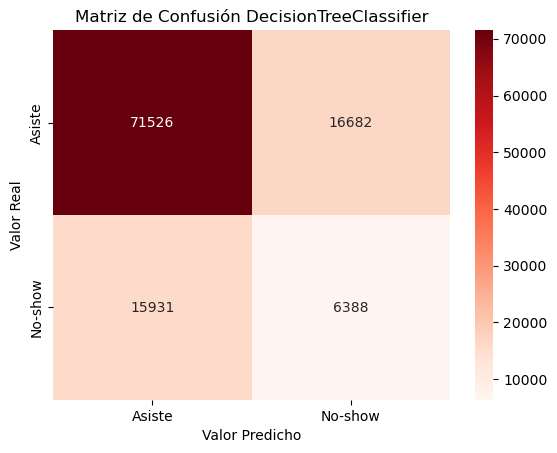

In [446]:
# Se define la variable objetivo y las variables predictoras
X = medical_appointments_transformed.drop('No-show', axis=1)
y = medical_appointments_transformed['No-show']

# Crear una instancia de DecisionTreeClassifier
clf_tree = DecisionTreeClassifier()

# Se realiza la validación cruzada para obtener predicciones para todo el conjunto de datos
y_pred = cross_val_predict(clf_tree, X, y, cv=5)

# Se crea una matriz de confusión
confusion_mat = confusion_matrix(y, y_pred)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)

# Configuración del gráfico
plt.title('Matriz de Confusión DecisionTreeClassifier')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

# Se calculan las métricas de evaluación
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, pos_label=1)
recall = recall_score(y, y_pred, pos_label=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
plt.show()

6. Balanceo de clases

Text(0.5, 1.0, 'Distribución de No-show en el dataset')

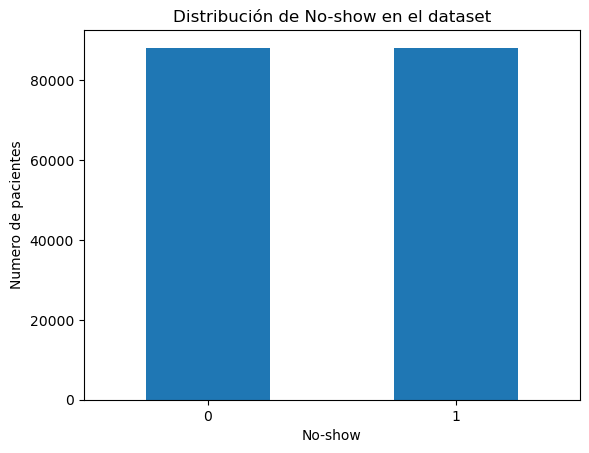

In [447]:
# Se crea una instancia de SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Se aplica SMOTE a los datos
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Se crea una instancia de la clase Pipeline
pipeline = Pipeline([('smote', smote), ('rus', rus)])

# Se aplica el pipeline a los datos
X_balanced, y_balanced = pipeline.fit_resample(X, y)

# Se grafica la distribución de las clases
class_counts = y_balanced.value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset')

7. Entrenamiento Regresión Logisitica (datos balanceados)

Accuracy (Datos Balanceados): 0.500005668420098
Precision (Datos Balanceados): 0.5000070854648774
Recall (Datos Balanceados): 0.4000090694721567


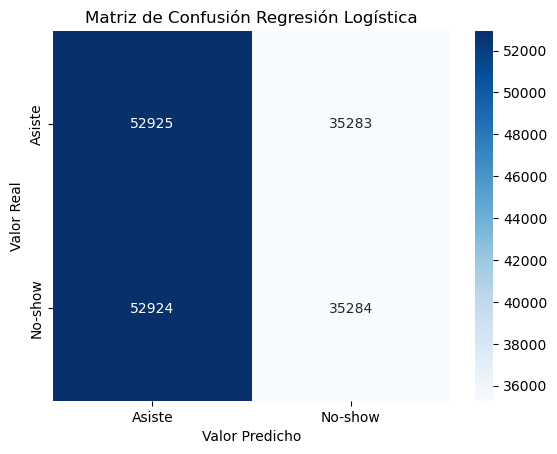

In [448]:

# Crear una instancia de LogisticRegression
clf_logistic = LogisticRegression(max_iter=1000) # Numero maximo de iteraciones

# Realizar la validación cruzada para obtener predicciones para todo el conjunto de datos balanceados
y_pred_balanced_logistic = cross_val_predict(clf_logistic, X_balanced, y_balanced, cv=5)

# Se crea una matriz de confusión
confusion_mat_balanced_logistic = confusion_matrix(y_balanced, y_pred_balanced_logistic)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Configuración del gráfico
plt.title('Matriz de Confusión Regresión Logística')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

# Se calculan las métricas de evaluación
accuracy_balanced_logistic = accuracy_score(y_balanced, y_pred_balanced_logistic)
precision_balanced_logistic = precision_score(y_balanced, y_pred_balanced_logistic, pos_label=1) 
recall_balanced_logistic = recall_score(y_balanced, y_pred_balanced_logistic, pos_label=1)

print("Accuracy (Datos Balanceados):", accuracy_balanced_logistic)
print("Precision (Datos Balanceados):", precision_balanced_logistic)
print("Recall (Datos Balanceados):", recall_balanced_logistic)
plt.show()


8. Entrenamiento de DecisionTreeClassifier (Datos balanceados)

Accuracy (Datos Balanceados): 0.7107178487212045
Precision (Datos Balanceados): 0.6794077334414393
Recall (Datos Balanceados): 0.7979775077090513


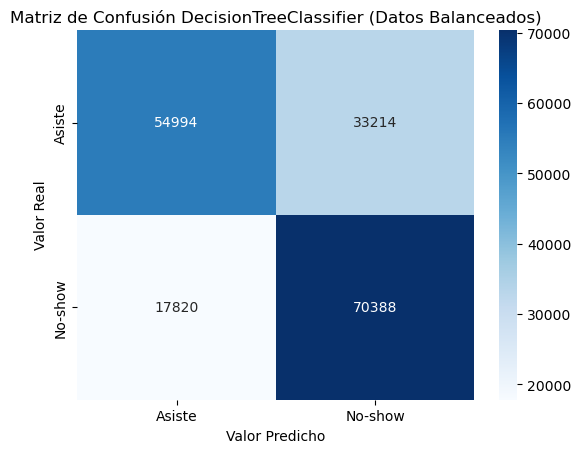

In [449]:
# Crear una instancia de DecisionTreeClassifier
clf_tree_balanced = DecisionTreeClassifier()

# Realizar la validación cruzada para obtener predicciones para todo el conjunto de datos balanceados
y_pred_balanced = cross_val_predict(clf_tree_balanced, X_balanced, y_balanced, cv=5)

# Se crea una matriz de confusión
confusion_mat_balanced = confusion_matrix(y_balanced, y_pred_balanced)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Configuración del gráfico
plt.title('Matriz de Confusión DecisionTreeClassifier (Datos Balanceados)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

# Se calculan las métricas de evaluación
accuracy_balanced = accuracy_score(y_balanced, y_pred_balanced)
precision_balanced = precision_score(y_balanced, y_pred_balanced, pos_label=1) 
recall_balanced = recall_score(y_balanced, y_pred_balanced, pos_label=1)

print("Accuracy (Datos Balanceados):", accuracy_balanced)
print("Precision (Datos Balanceados):", precision_balanced)
print("Recall (Datos Balanceados):", recall_balanced)
plt.show()


9. Entrenamiento Support Vector Machine (SVM), (datos balanceados)

In [450]:
# Crear una instancia de SVC
clf_svc = SVC(kernel='rbf', gamma='scale')

# Realizar la validación cruzada para obtener predicciones para todo el conjunto de datos balanceados
y_pred_balanced_svc = cross_val_predict(clf_svc, X_balanced, y_balanced, cv=5)

# Se crea una matriz de confusión
confusion_mat_balanced_svc = confusion_matrix(y_balanced, y_pred_balanced_svc)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced_svc, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Configuración del gráfico
plt.title('Matriz de Confusión SVM (Datos Balanceados)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

# Se calculan las métricas de evaluación
accuracy_balanced_svc = accuracy_score(y_balanced, y_pred_balanced_svc)
precision_balanced_svc = precision_score(y_balanced, y_pred_balanced_svc, pos_label=1) 
recall_balanced_svc = recall_score(y_balanced, y_pred_balanced_svc, pos_label=1)

print("Accuracy (Datos Balanceados):", accuracy_balanced_svc)
print("Precision (Datos Balanceados):", precision_balanced_svc)
print("Recall (Datos Balanceados):", recall_balanced_svc)
plt.show()


10. Entrneamiento de random forest Classifier

Accuracy (Datos Balanceados): 0.7107121803011065
Precision (Datos Balanceados): 0.6798142504716297
Recall (Datos Balanceados): 0.7966284237257392


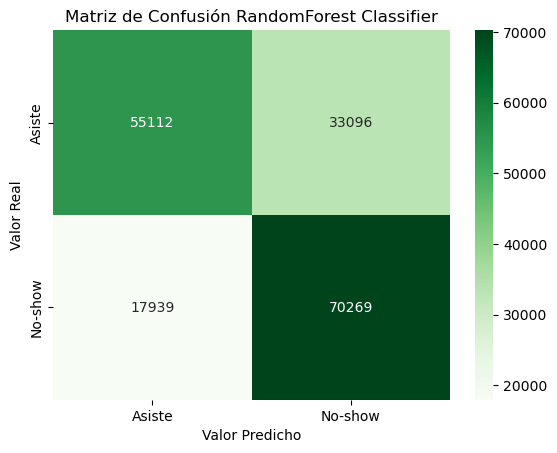

[[55112 33096]
 [17939 70269]]


In [ ]:
# Crear una instancia de RandomForestClassifier con parámetros predeterminados
rf_balanced = RandomForestClassifier(
    n_estimators=100,     # Numero de arboles
    max_depth=20,         # Profundidad del arbol, evita el sobreajuste
    min_samples_split=4,  # Aumentar este valor puede ayudar a evitar que el modelo se sobreajuste a los datos de entrenamiento.
    min_samples_leaf=2,   # Un valor más alto ayuda a suavizar el modelo, especialmente en problemas de clasificación.
    max_features='sqrt',  # Reducir el número de características consideradas para las divisiones puede hacer que el modelo sea más robusto.
    random_state=42,      # Fijar una semilla para reproducibilidad.
    class_weight='balanced'  # Clasees balanceadas
)

# Realizar la validación cruzada para obtener predicciones para todo el conjunto de datos
y_pred_prob_balanced = cross_val_predict(rf_balanced, X_balanced, y_balanced, cv=5, method='predict_proba')

# Se crea una matriz de confusión
confusion_mat_balanced = confusion_matrix(y_balanced, y_pred_balanced)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)

# Configuración del gráfico
plt.title('Matriz de Confusión RandomForest Classifier')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

# Se calculan las métricas de evaluación
accuracy_balanced = accuracy_score(y_balanced, y_pred_balanced)
precision_balanced = precision_score(y_balanced, y_pred_balanced)
recall_balanced = recall_score(y_balanced, y_pred_balanced)

print("Accuracy (Datos Balanceados):", accuracy_balanced)
print("Precision (Datos Balanceados):", precision_balanced)
print("Recall (Datos Balanceados):", recall_balanced)
plt.show()
print(confusion_mat_balanced)

In [ ]:
# Se obtiene la probabilidad de inasistencia
prob_inasistencia = y_pred_prob_balanced[:, 1]
user_ids = ...
usuarios_prob_df = pd.DataFrame({'UserId': user_ids, 'Probabilidad_Inasistencia': prob_inasistencia})

# Se exporta a un archivo CSV
usuarios_prob_df.to_csv('listado_probabilidad_inasistencia.csv', index=False)

# Se carga el archivo CSV
usuarios_prob_df = pd.read_csv('listado_probabilidad_inasistencia.csv')
usuarios_prob_df.head(10)

,UserId,Probabilidad_Inasistencia
0,Ellipsis,0.792699
1,Ellipsis,0.933294
2,Ellipsis,0.941492
3,Ellipsis,0.939950
4,Ellipsis,0.725366
5,Ellipsis,0.913456
6,Ellipsis,0.889445
7,Ellipsis,0.966454
8,Ellipsis,0.992056
9,Ellipsis,0.943549
